# Monitorización de equipos industriales para detección de fallos


### 1. Importación de librerias

In [436]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from imblearn.over_sampling import SMOTE
import optuna

### 2. Carga del csv

In [437]:
df = pd.read_csv("equipment_anomaly_data.csv")
df.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


### 3. Detección de anomalías

In [438]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


In [439]:
df.describe()

,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922478,35.738048,1.611809,50.016574,0.099974
std,16.200059,10.381593,0.728560,11.841479,0.299985
min,10.269385,3.620798,-0.428188,10.215077,0.000000
25%,62.777057,29.485682,1.170906,42.612817,0.000000
50%,70.156900,35.227544,1.533113,50.024744,0.000000
75%,77.568387,41.159913,1.924700,57.340513,0.000000
max,149.690420,79.887734,4.990537,89.984718,1.000000


In [440]:
df.isnull().sum()

temperature    0
pressure       0
vibration      0
humidity       0
equipment      0
location       0
faulty         0
dtype: int64

In [441]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7667    False
7668    False
7669    False
7670    False
7671    False
Length: 7672, dtype: bool

In [442]:
df.columns

Index(['temperature', 'pressure', 'vibration', 'humidity', 'equipment',
       'location', 'faulty'],
      dtype='object')

### 4. Visualización de datos

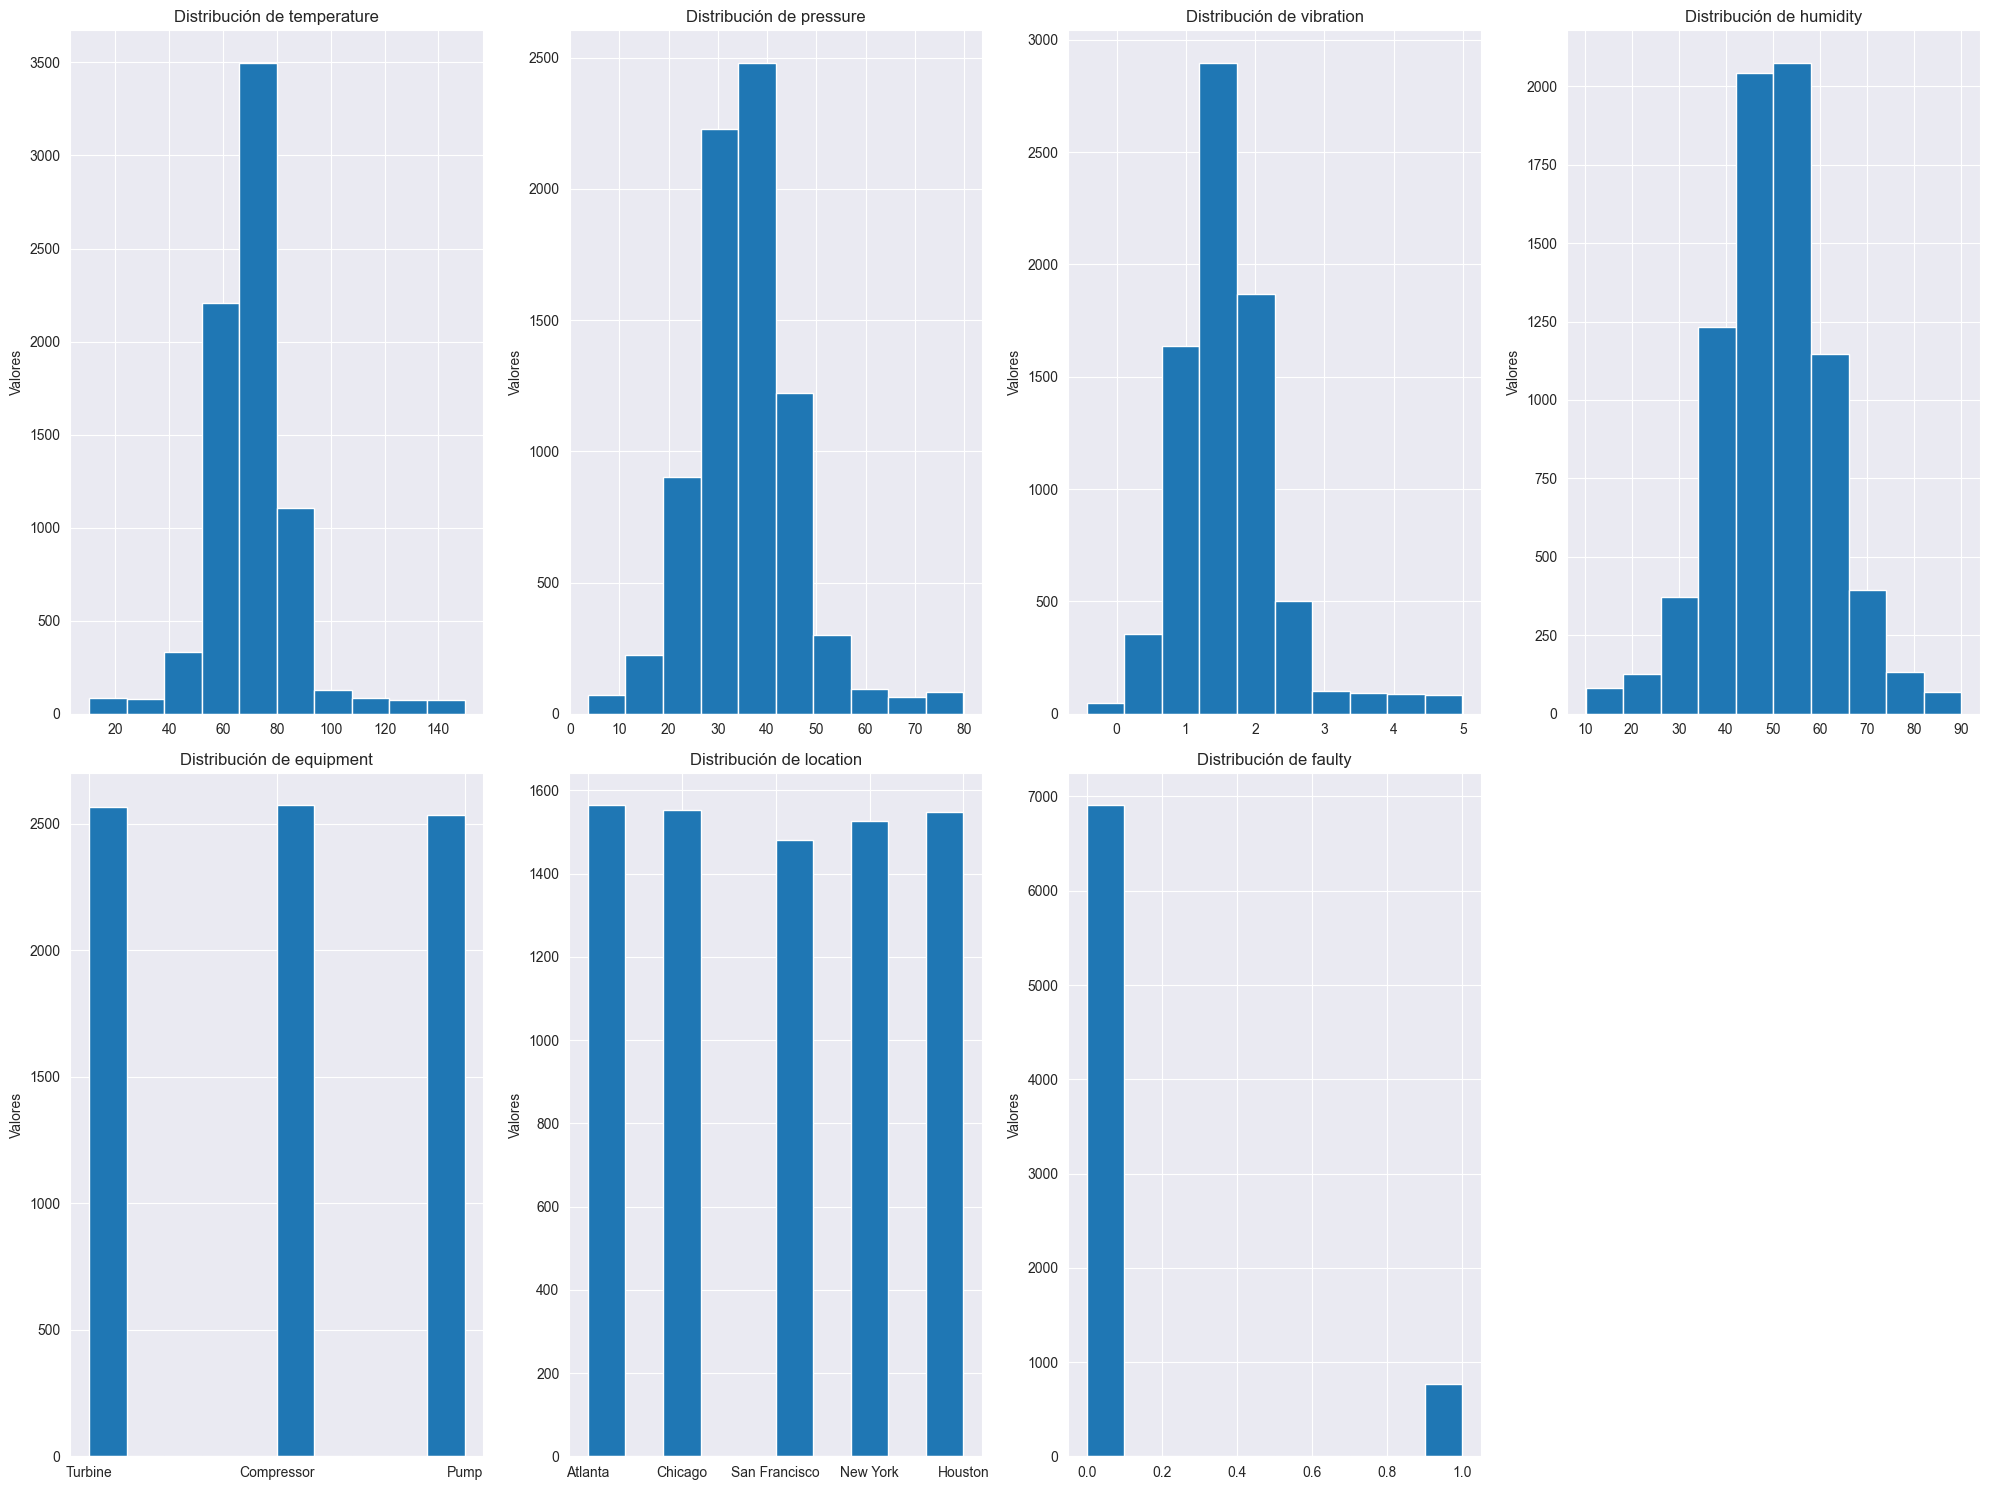

In [443]:
categorias = ['temperature', 'pressure', 'vibration', 'humidity', 'equipment','location', 'faulty']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 15))
axes = axes.flatten()
for i, var in enumerate(categorias):
 axes[i].hist(df[var])
 axes[i].set_title(f'Distribución de {var}')
 axes[i].set_ylabel('Valores')
for j in range(len(categorias), len(axes)):
 axes[j].axis('off')
plt.tight_layout()
plt.show()

In [444]:
df['equipment'].value_counts()

equipment
Compressor    2573
Turbine       2565
Pump          2534
Name: count, dtype: int64

In [445]:
df['location'].value_counts()

location
Atlanta          1564
Chicago          1553
Houston          1548
New York         1526
San Francisco    1481
Name: count, dtype: int64

In [446]:
df['faulty'].value_counts()

faulty
0.0    6905
1.0     767
Name: count, dtype: int64

De acuerdo con la ingeniería de características realizaremos `OneHotEncoder` para `equipment` y para `location`, en el caso de `faulty` necesitaremos realizar resample porque hay demasiados defectuosos en comparación con los que no

### 5. Ingeniería de características

In [447]:
# Instanciar OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Crea un array en vez de una matriz

# Aplicar el encoder a las columnas categóricas
categoricas = ['location', 'equipment']
valores = encoder.fit_transform(df[categoricas])

# Crear un DataFrame con los valores codificados
columnas_codificadas = encoder.get_feature_names_out(categoricas)
df_codificado = pd.DataFrame(valores, columns=columnas_codificadas, index=df.index)

# Concatenar el DataFrame original con las columnas codificadas
df = pd.concat([df.drop(columns=categoricas, axis=1), df_codificado], axis=1)

In [448]:
df.head()

,temperature,pressure,vibration,humidity,faulty,location_Atlanta,location_Chicago,location_Houston,location_New York,location_San Francisco,equipment_Compressor,equipment_Pump,equipment_Turbine
0,58.180180,25.029278,0.606516,45.694907,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,75.740712,22.954018,2.338095,41.867407,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,71.358594,27.276830,1.389198,58.954409,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,71.616985,32.242921,1.770690,40.565138,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,66.506832,45.197471,0.345398,43.253795,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [449]:
df.shape

(7672, 13)

In [450]:
# # Nos interesan los cuartiles del 25% y 75%
# categorias = ['temperature', 'pressure', 'vibration', 'humidity']
# Q1, Q3 = np.percentile(df['temperature'], [25, 75])
# IQR = Q3 - Q1
# outliers = []
# for elemento in df['temperature']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers.append(elemento)
# outliers

In [451]:
# df = df[~df['temperature'].isin(outliers)]
# df.shape

In [452]:
# Q1, Q3 = np.percentile(df['pressure'], [25, 75])
# IQR = Q3 - Q1
# outliers2 = []
# for elemento in df['pressure']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers2.append(elemento)
# outliers2

In [453]:
# df = df[~df['pressure'].isin(outliers2)]
# df.shape

In [454]:
# Q1, Q3 = np.percentile(df['vibration'], [25, 75])
# IQR = Q3 - Q1
# outliers2 = []
# for elemento in df['vibration']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers2.append(elemento)
# outliers2

In [455]:
# df = df[~df['vibration'].isin(outliers2)]
# df.shape

In [456]:
# Q1, Q3 = np.percentile(df['humidity'], [25, 75])
# IQR = Q3 - Q1
# outliers2 = []
# for elemento in df['humidity']:
#  if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
#   outliers2.append(elemento)
# outliers2

In [457]:
# df = df[~df['humidity'].isin(outliers2)]
# df.shape

Aplicando el rango intercuartílico hemos eliminado los outliers de las variables numericas, pero si recordamos la visaulización del prinicpio hemos visto que la variable objetivo tiene muchos datos de la clase 0 y muy pocos de la 1, vamos a reajustar este inconveniente

In [458]:
# # Supongamos que separamos clases mayoritaria y minoritaria
# df_major = df[df['faulty'] == 0]
# df_minor = df[df['faulty'] == 1]
# # Ahora hacemos oversampling de la clase minoritaria
# df_minor_oversampled = resample(df_minor,
# replace=True,n_samples=len(df_major), random_state=42)
# # Combinar las clases
# df_balanced = pd.concat([df_major, df_minor_oversampled])

In [459]:
# plt.hist(df_balanced['faulty'])

Después de aplicar `resample` se puede apreciar que las clases están equilibradas, a continuación se procederá al entrenamiento del modelo

### 6. Entrenamiento del modelo

Primero se escalará el dataframe ya que es de obligado cumplimiento para una red neuronal a diferencia de cualquier modelo de ML

In [460]:
X = df.drop('faulty',axis=1)
y = df['faulty']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creamos la red neuronal con 3 capas ocultas, todas de activación `relu` y un `Dropout` del 0.5 y 0.3 respectivamente por la reducción de capas ocultas a medida que el entrenamiento avanza

In [461]:
# Creamos el modelo de red neuronal
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model = Sequential([
 Input(shape=(X_train.shape[1],)), # Definir forma de la entrada
    Dense(32, activation='relu'), # 1a capa oculta
    Dropout(0.5),
    Dense(16, activation='relu'), # 1a capa oculta
    Dropout(0.3),
    Dense(8, activation='relu'), # 2a capa oculta
    Dense(1, activation='sigmoid') # Salida
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# Mostramos configuración
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

In [462]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6124 - loss: 0.6854 - val_accuracy: 0.8974 - val_loss: 0.3742
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8967 - loss: 0.3873 - val_accuracy: 0.8974 - val_loss: 0.2897
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9079 - loss: 0.3149 - val_accuracy: 0.9064 - val_loss: 0.2521
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9262 - loss: 0.2583 - val_accuracy: 0.9308 - val_loss: 0.2237
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9264 - loss: 0.2664 - val_accuracy: 0.9438 - val_loss: 0.1999
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9320 - loss: 0.2416 - val_accuracy: 0.9495 - val_loss: 0.1811
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9424 - loss: 0.2214 - val_accuracy: 0.9536 - val_loss: 0.1684
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9378 - loss: 0.2138 - val_accuracy: 0.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9751 - loss: 0.0847
Pérdida: 0.08906843513250351, Precisión: 0.9758957624435425


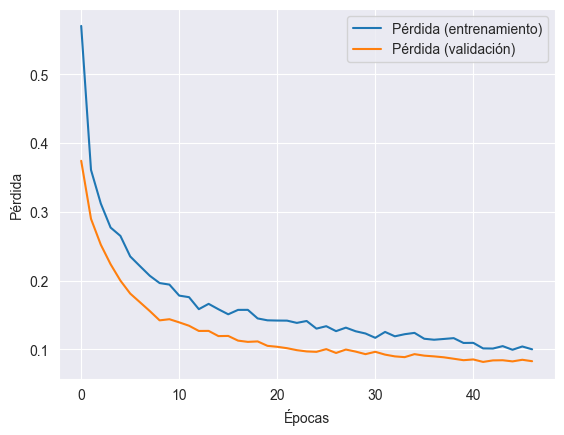

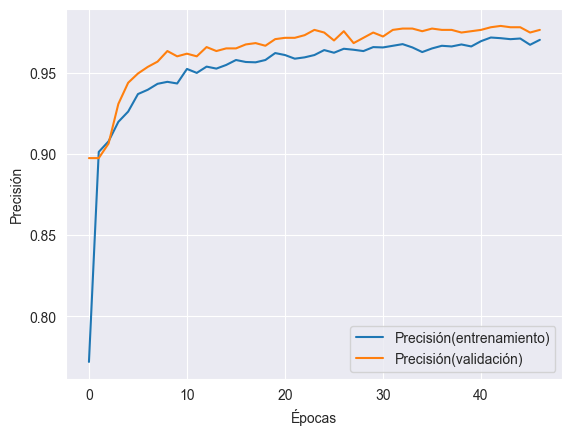

In [463]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")
# Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
# Precisión
plt.plot(history.history['accuracy'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

A primera vista de las gráficas se puede apreciar un claro overfitting del modelo, en el cuál no se distingue en absoluto una mejoría

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Reporte de Clasificación:
                  precision    recall  f1-score   support

No Mantenimiento       0.98      1.00      0.99      1377
   Mantenimiento       0.98      0.78      0.87       158

        accuracy                           0.98      1535
       macro avg       0.98      0.89      0.93      1535
    weighted avg       0.98      0.98      0.97      1535



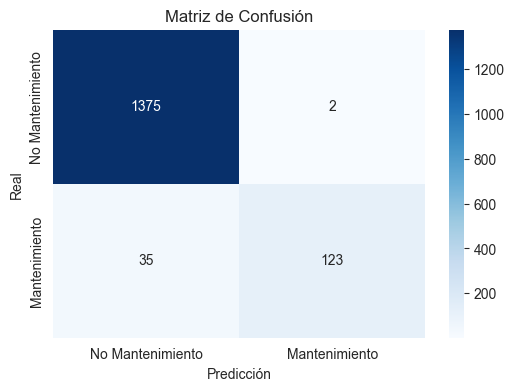

In [464]:
def train_validation(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convertir probabilidades en etiquetas binarias

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Mantenimiento", "Mantenimiento"]))

    # Mostrar matriz de confusión con heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Mantenimiento", "Mantenimiento"],
                yticklabels=["No Mantenimiento", "Mantenimiento"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)

Al igual que se visualizó con las gráficas, la matriz de confusión confirma lo afirmado, a continuación se realizará un ajuste de hiperparámetros mediante `RandomSearch` y `SMOTE` por el desbalanceo de clases

In [465]:
def build_model(hp):
 model = Sequential([
     Dense(units=hp.Int('units', min_value=32, max_value=512,step=32), activation='relu'),
     Dense(1)
 ])

 model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01])),loss='mean_squared_error',metrics=['mae'])
 return model

tuner = RandomSearch(
 build_model,
 objective='val_loss',
 max_trials=5,
 directory='./my_dir',
 project_name='prediccion'
)
tuner.search(X_train, y_train, validation_split=0.2)

Reloading Tuner from ./my_dir\prediccion\tuner0.json


In [466]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [467]:
best_model = tuner.hypermodel.build(best_hps)

In [468]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [469]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_split, y_train_split)  # Solo en los datos de entrenamiento

In [470]:
# Ahora usa X_resampled, y_resampled en el entrenamiento
history = best_model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1234 - mae: 0.2634 - val_loss: 0.0427 - val_mae: 0.1550
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0641 - mae: 0.1925 - val_loss: 0.0810 - val_mae: 0.2222
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0589 - mae: 0.1829 - val_loss: 0.0490 - val_mae: 0.1676
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0546 - mae: 0.1729 - val_loss: 0.0401 - val_mae: 0.1457
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0530 - mae: 0.1688 - val_loss: 0.0472 - val_mae: 0.1595
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0527 - mae: 0.1686 - val_loss: 0.0468 - val_mae: 0.1598
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0512 - mae: 0.1648 - val_loss: 0.0542 - val_mae: 0.1737
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0491 - mae: 0.1631 - val_loss: 0.0501 - val_mae: 0.1669
Epoch 9/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Reporte de Clasificación:
                  precision    recall  f1-score   support

No Mantenimiento       0.93      0.99      0.96      4429
   Mantenimiento       0.99      0.93      0.96      4429

        accuracy                           0.96      8858
       macro avg       0.96      0.96      0.96      8858
    weighted avg       0.96      0.96      0.96      8858



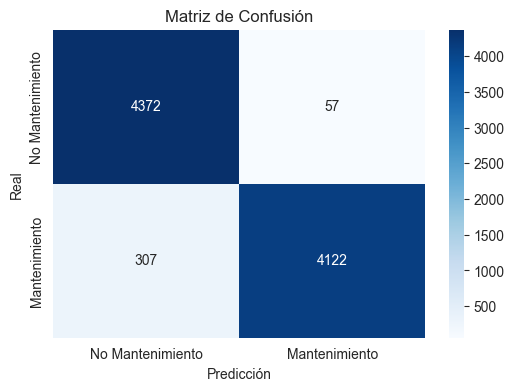

In [471]:
train_validation(best_model, X_resampled, y_resampled)

Ahora se puede apreciar una notoria mejoría con respecto al desempeño del modelo, donde se encuentra una precisión para la clase 0 del 0.99 y para la clase 1 una precisión del 0.94, así mismo, en la matriz de confusión se encuentra un número de falsos positivos bastante reducido en comparación con el resto de conclusiones

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0426 - mae: 0.1508
Pérdida: 0.04568326845765114, Precisión: 0.15419180691242218


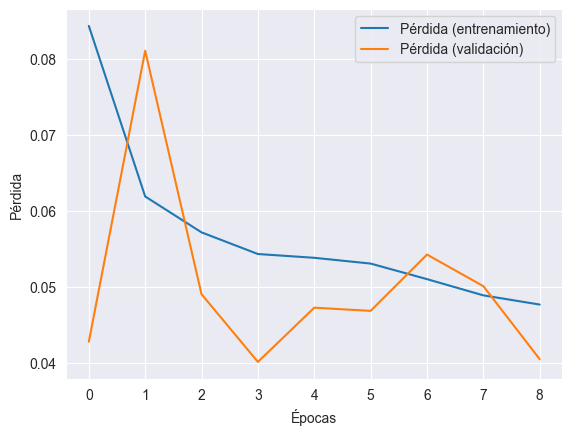

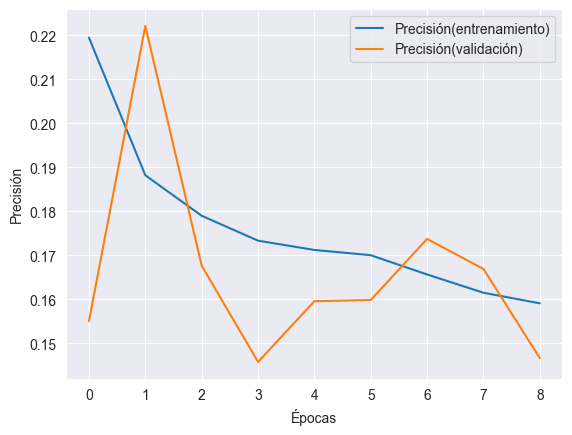

In [472]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")
# Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
# Precisión
plt.plot(history.history['mae'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_mae'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [473]:
# Definir la función objetivo que Optuna optimizará
def objective(trial):
 # Espacios de búsqueda de hiperparámetros (esto son ejemplos)
 units = trial.suggest_int('units', 32, 512, step=32)
 lr = trial.suggest_categorical('learning_rate', [0.001, 0.01,0.1])

 # Crear el modelo
 model = Sequential([
    Input(shape=(X_resampled.shape[1],)), # Definir forma de la entrada
    Dense(units=units, activation='relu'),
    Dense(1, activation='sigmoid')
 ])

 model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss='mean_squared_error',metrics=['mae'])

 model.fit(X_resampled, y_resampled, epochs=50, validation_split=0.2, verbose=1)

 # Obtener la pérdida en la validación para optimizar
 val_loss = model.history.history['val_loss'][-1]
 return val_loss
# Crear estudio de Optuna y ejecutar la optimización
# Queremos minimizar la pérdida (val_loss)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10) # 5 intentos de prueba, puedes aumentar este número
# Mostrar los mejores hiperparámetros encontrados
print(f'Best hyperparameters: {study.best_params}')


[I 2025-02-05 18:04:14,310] A new study created in memory with name: no-name-5c65fc25-6178-4b8d-8034-91a0fef79fa2


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1597 - mae: 0.3649 - val_loss: 0.0950 - val_mae: 0.2275
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0587 - mae: 0.1874 - val_loss: 0.0712 - val_mae: 0.1646
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0406 - mae: 0.1320 - val_loss: 0.0547 - val_mae: 0.1255
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0355 - mae: 0.1115 - val_loss: 0.0471 - val_mae: 0.1071
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320 - mae: 0.0978 - val_loss: 0.0520 - val_mae: 0.1097
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0299 - mae: 0.0872 - val_loss: 0.0488 - val_mae: 0.1024
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 - mae: 0.0792 - val_loss: 0.0487 - val_mae: 0.0980
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0273 - mae: 0.0766 - val_loss: 0.0441 - val_mae: 0.0874
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-05 18:04:39,291] Trial 0 finished with value: 0.027532856911420822 and parameters: {'units': 160, 'learning_rate': 0.001}. Best is trial 0 with value: 0.027532856911420822.


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1868 - mae: 0.2027 - val_loss: 0.1018 - val_mae: 0.1027
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2418 - mae: 0.2429 - val_loss: 0.3827 - val_mae: 0.3836
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1484 - mae: 0.1490 - val_loss: 0.3713 - val_mae: 0.3723
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1794 - mae: 0.1796 - val_loss: 0.4061 - val_mae: 0.4064
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1518 - mae: 0.1524 - val_loss: 0.3307 - val_mae: 0.3307
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1747 - mae: 0.1749 - val_loss: 0.4029 - val_mae: 0.4030
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1873 - mae: 0.1875 - val_loss: 0.2469 - val_mae: 0.2471
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1452 - mae: 0.1455 - val_loss: 0.3211 - val_mae: 0.3211
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-05 18:05:04,208] Trial 1 finished with value: 0.18171557784080505 and parameters: {'units': 160, 'learning_rate': 0.1}. Best is trial 0 with value: 0.027532856911420822.


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0907 - mae: 0.1900 - val_loss: 0.0613 - val_mae: 0.0936
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0373 - mae: 0.0645 - val_loss: 0.0620 - val_mae: 0.0852
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352 - mae: 0.0570 - val_loss: 0.0638 - val_mae: 0.0837
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0384 - mae: 0.0559 - val_loss: 0.0555 - val_mae: 0.0704
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0308 - mae: 0.0448 - val_loss: 0.1101 - val_mae: 0.1373
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0328 - mae: 0.0464 - val_loss: 0.0993 - val_mae: 0.1236
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334 - mae: 0.0453 - val_loss: 0.0284 - val_mae: 0.0367
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0321 - mae: 0.0427 - val_loss: 0.0336 - val_mae: 0.0421
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-05 18:05:29,253] Trial 2 finished with value: 0.07248912751674652 and parameters: {'units': 384, 'learning_rate': 0.01}. Best is trial 0 with value: 0.027532856911420822.


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0811 - mae: 0.1707 - val_loss: 0.0693 - val_mae: 0.0954
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0400 - mae: 0.0662 - val_loss: 0.0530 - val_mae: 0.0763
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0388 - mae: 0.0601 - val_loss: 0.0534 - val_mae: 0.0724
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0284 - mae: 0.0454 - val_loss: 0.0610 - val_mae: 0.0819
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306 - mae: 0.0448 - val_loss: 0.0811 - val_mae: 0.1055
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0340 - mae: 0.0473 - val_loss: 0.0841 - val_mae: 0.1024
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315 - mae: 0.0430 - val_loss: 0.0486 - val_mae: 0.0595
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320 - mae: 0.0428 - val_loss: 0.0428 - val_mae: 0.0550
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-05 18:05:55,054] Trial 3 finished with value: 0.04519277065992355 and parameters: {'units': 352, 'learning_rate': 0.01}. Best is trial 0 with value: 0.027532856911420822.


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0800 - mae: 0.1648 - val_loss: 0.0790 - val_mae: 0.1130
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0425 - mae: 0.0687 - val_loss: 0.0535 - val_mae: 0.0721
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0344 - mae: 0.0515 - val_loss: 0.0640 - val_mae: 0.0872
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339 - mae: 0.0500 - val_loss: 0.0695 - val_mae: 0.0843
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0408 - mae: 0.0532 - val_loss: 0.0518 - val_mae: 0.0650
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361 - mae: 0.0474 - val_loss: 0.0282 - val_mae: 0.0346
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0397 - mae: 0.0505 - val_loss: 0.0710 - val_mae: 0.0838
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0351 - mae: 0.0438 - val_loss: 0.0536 - val_mae: 0.0627
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-05 18:06:20,432] Trial 4 finished with value: 0.05235202610492706 and parameters: {'units': 480, 'learning_rate': 0.01}. Best is trial 0 with value: 0.027532856911420822.


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1741 - mae: 0.3913 - val_loss: 0.1184 - val_mae: 0.2645
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0697 - mae: 0.2092 - val_loss: 0.0706 - val_mae: 0.1716
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0482 - mae: 0.1553 - val_loss: 0.0588 - val_mae: 0.1400
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0378 - mae: 0.1230 - val_loss: 0.0507 - val_mae: 0.1175
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0360 - mae: 0.1095 - val_loss: 0.0563 - val_mae: 0.1196
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326 - mae: 0.0975 - val_loss: 0.0508 - val_mae: 0.1094
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314 - mae: 0.0904 - val_loss: 0.0429 - val_mae: 0.0924
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284 - mae: 0.0818 - val_loss: 0.0451 - val_mae: 0.0952
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-05 18:06:44,882] Trial 5 finished with value: 0.03260563313961029 and parameters: {'units': 96, 'learning_rate': 0.001}. Best is trial 0 with value: 0.027532856911420822.


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2720 - mae: 0.2824 - val_loss: 0.9863 - val_mae: 0.9865
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3490 - mae: 0.3491 - val_loss: 0.5459 - val_mae: 0.5461
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2704 - mae: 0.2705 - val_loss: 0.5961 - val_mae: 0.5963
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3205 - mae: 0.3205 - val_loss: 0.5045 - val_mae: 0.5046
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2511 - mae: 0.2513 - val_loss: 0.5328 - val_mae: 0.5329
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2568 - mae: 0.2568 - val_loss: 0.5327 - val_mae: 0.5327
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2641 - mae: 0.2642 - val_loss: 0.3883 - val_mae: 0.3883
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3007 - mae: 0.3008 - val_loss: 0.3908 - val_mae: 0.3909
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-05 18:07:10,576] Trial 6 finished with value: 0.4802483022212982 and parameters: {'units': 512, 'learning_rate': 0.1}. Best is trial 0 with value: 0.027532856911420822.


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1700 - mae: 0.3790 - val_loss: 0.0899 - val_mae: 0.2200
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0590 - mae: 0.1889 - val_loss: 0.0630 - val_mae: 0.1531
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0410 - mae: 0.1333 - val_loss: 0.0550 - val_mae: 0.1251
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0349 - mae: 0.1079 - val_loss: 0.0478 - val_mae: 0.1074
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0291 - mae: 0.0906 - val_loss: 0.0498 - val_mae: 0.1062
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284 - mae: 0.0831 - val_loss: 0.0408 - val_mae: 0.0874
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0290 - mae: 0.0799 - val_loss: 0.0479 - val_mae: 0.0949
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271 - mae: 0.0744 - val_loss: 0.0502 - val_mae: 0.0966
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

[I 2025-02-05 18:07:34,943] Trial 7 finished with value: 0.03085894137620926 and parameters: {'units': 160, 'learning_rate': 0.001}. Best is trial 0 with value: 0.027532856911420822.


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1374 - mae: 0.3279 - val_loss: 0.0702 - val_mae: 0.1695
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0432 - mae: 0.1380 - val_loss: 0.0505 - val_mae: 0.1154
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0343 - mae: 0.1042 - val_loss: 0.0674 - val_mae: 0.1313
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288 - mae: 0.0837 - val_loss: 0.0512 - val_mae: 0.1038
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 - mae: 0.0753 - val_loss: 0.0491 - val_mae: 0.0991
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0286 - mae: 0.0722 - val_loss: 0.0458 - val_mae: 0.0863
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255 - mae: 0.0657 - val_loss: 0.0489 - val_mae: 0.0905
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244 - mae: 0.0609 - val_loss: 0.0493 - val_mae: 0.0908
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

[I 2025-02-05 18:08:07,040] Trial 8 finished with value: 0.020638274028897285 and parameters: {'units': 448, 'learning_rate': 0.001}. Best is trial 8 with value: 0.020638274028897285.


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1122 - mae: 0.1615 - val_loss: 0.1310 - val_mae: 0.1410
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0648 - mae: 0.0726 - val_loss: 0.1422 - val_mae: 0.1489
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0786 - mae: 0.0839 - val_loss: 0.1236 - val_mae: 0.1276
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0658 - mae: 0.0689 - val_loss: 0.1925 - val_mae: 0.1961
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0882 - mae: 0.0904 - val_loss: 0.0462 - val_mae: 0.0474
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0860 - mae: 0.0888 - val_loss: 0.1271 - val_mae: 0.1283
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0855 - mae: 0.0870 - val_loss: 0.1128 - val_mae: 0.1137
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0958 - mae: 0.0971 - val_loss: 0.1486 - val_mae: 0.1508
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

[I 2025-02-05 18:08:38,203] Trial 9 finished with value: 0.12083804607391357 and parameters: {'units': 32, 'learning_rate': 0.1}. Best is trial 8 with value: 0.020638274028897285.


Best hyperparameters: {'units': 448, 'learning_rate': 0.001}


In [474]:
best_params = study.best_params  # Obtener los mejores hiperparámetros encontrados

# Crear y entrenar el mejor modelo
best_model = Sequential([
    Input(shape=(X_resampled.shape[1],)), # Definir forma de la entrada
    Dense(units=best_params['units'], activation='relu'),
    Dense(1, activation='sigmoid')  # Asegúrate de que la activación final sea adecuada
])

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='mean_squared_error',
    metrics=['mae']
)

best_model.fit(X_resampled, y_resampled, epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1375 - mae: 0.3287 - val_loss: 0.0865 - val_mae: 0.1944
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0403 - mae: 0.1311 - val_loss: 0.0562 - val_mae: 0.1207
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 - mae: 0.0987 - val_loss: 0.0489 - val_mae: 0.1026
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0293 - mae: 0.0841 - val_loss: 0.0522 - val_mae: 0.0995
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0290 - mae: 0.0769 - val_loss: 0.0656 - val_mae: 0.1169
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0262 - mae: 0.0678 - val_loss: 0.0426 - val_mae: 0.0846
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0265 - mae: 0.0683 - val_loss: 0.0498 - val_mae: 0.0923
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0263 - mae: 0.0638 - val_loss: 0.0429 - val_mae: 0.0793
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Reporte de Clasificación:
                  precision    recall  f1-score   support

No Mantenimiento       0.98      0.99      0.98      4429
   Mantenimiento       0.99      0.98      0.98      4429

        accuracy                           0.98      8858
       macro avg       0.98      0.98      0.98      8858
    weighted avg       0.98      0.98      0.98      8858



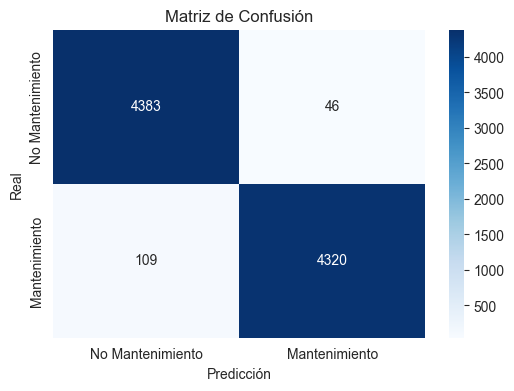

In [475]:
train_validation(best_model, X_resampled, y_resampled)